# Machine Learning in Python - Project 2

Due Friday, Apr 11th by 4 pm.

*Include contributors names in notebook metadata or here*

## Setup

*Install any packages here, define any functions if neeed, and load data*

In [2]:
# Add any additional libraries or submodules below

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from sklearn.model_selection import train_test_split

In [12]:
# Load data in easyshare.csv
d = pd.read_csv("freddiemac.csv", dtype={
    'cd_msa': str,
    'zipcode': str,
    'id_loan_rr': str, 
    'rr_ind':str})
d.head()

,fico,dt_first_pi,flag_fthb,dt_matr,cd_msa,mi_pct,cnt_units,occpy_sts,cltv,dti,...,seller_name,servicer_name,flag_sc,id_loan_rr,program_ind,rr_ind,property_val,io_ind,mi_cancel_ind,loan_status
0,809,201705,N,204704,NaN,0,1,P,75,38,...,Other sellers,SPECIALIZED LOAN SERVICING LLC,NaN,NaN,9,NaN,2,N,7,prepaid
1,702,201703,N,203202,NaN,0,1,P,80,36,...,Other sellers,Other servicers,NaN,NaN,9,NaN,2,N,7,active
2,792,201703,N,204702,NaN,0,1,S,60,36,...,Other sellers,Other servicers,NaN,NaN,9,NaN,2,N,7,prepaid
3,776,201703,N,204702,NaN,0,1,S,80,18,...,Other sellers,Other servicers,NaN,NaN,9,NaN,2,N,7,prepaid
4,790,201703,N,204702,41620,0,1,I,75,42,...,Other sellers,"PNC BANK, NA",NaN,NaN,9,NaN,2,N,7,active


# Introduction

*This section should include a brief introduction to the task and the data (assume this is a report you are delivering to a professional body (e.g. Freddie Mac).*

*Briefly outline the approaches being used and the conclusions that you are able to draw.*

# Exploratory Data Analysis and Feature Engineering

*Include a detailed discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling. Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up. Think carefully about whether each plot needs to be included in your final draft and the appropriate type of plot and summary for each variable type - your report should include figures but they should be as focused and impactful as possible.*

*You should also split your data into training and testing sets, ideally before you look to much into the features and relationships with the target*

*Additionally, this section should also motivate and describe any preprocessing / feature engineering of the data. Specifically, this should be any code that you use to generate new columns in the data frame `d`. Pipelines should be used and feature engineering steps that are be performed as part of an sklearn pipeline can be mentioned here but should be implemented in the following section.*

*All code and figures should be accompanied by text that provides an overview / context to what is being done or presented.*

In [13]:
# For general info 
d.info()

# For the summary statistics
d.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 33 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   fico            200000 non-null  int64  
 1   dt_first_pi     200000 non-null  int64  
 2   flag_fthb       200000 non-null  object 
 3   dt_matr         200000 non-null  int64  
 4   cd_msa          181072 non-null  object 
 5   mi_pct          200000 non-null  int64  
 6   cnt_units       200000 non-null  int64  
 7   occpy_sts       200000 non-null  object 
 8   cltv            200000 non-null  int64  
 9   dti             200000 non-null  int64  
 10  orig_upb        200000 non-null  int64  
 11  ltv             200000 non-null  int64  
 12  int_rt          200000 non-null  float64
 13  channel         200000 non-null  object 
 14  ppmt_pnlty      200000 non-null  object 
 15  prod_type       200000 non-null  object 
 16  st              200000 non-null  object 
 17  prop_type 

,fico,dt_first_pi,dt_matr,mi_pct,cnt_units,cltv,dti,orig_upb,ltv,int_rt,orig_loan_term,cnt_borr,property_val
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,2.000000e+05,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,751.633305,201872.544595,204589.510570,7.189460,1.030270,74.673945,46.476695,2.508000e+05,74.374545,4.089462,327.003335,1.479765,1.891110
std,139.867834,117.328717,570.809083,11.939546,0.229878,17.874559,105.665503,1.305104e+05,17.400913,0.755975,67.594506,0.514025,0.417377
min,458.000000,201702.000000,202502.000000,0.000000,1.000000,5.000000,1.000000,1.100000e+04,5.000000,0.000000,96.000000,1.000000,1.000000
25%,719.000000,201803.000000,204705.000000,0.000000,1.000000,66.000000,28.000000,1.510000e+05,66.000000,3.625000,360.000000,1.000000,2.000000
50%,758.000000,201903.000000,204807.000000,0.000000,1.000000,80.000000,36.000000,2.270000e+05,80.000000,4.125000,360.000000,1.000000,2.000000
75%,787.000000,202003.000000,204909.000000,12.000000,1.000000,88.000000,43.000000,3.300000e+05,86.000000,4.625000,360.000000,2.000000,2.000000
max,9999.000000,202205.000000,206303.000000,999.000000,4.000000,999.000000,999.000000,1.088000e+06,999.000000,6.750000,516.000000,5.000000,9.000000


In [14]:
# ## 2. Filter Active Loans and Check Target Distribution

# Filter out active loans (only keep 'default' and 'prepaid')
d_filtered = d[d['loan_status'].isin(['default', 'prepaid'])].copy()
print("Data shape after filtering active loans:", d_filtered.shape)

# Check target distribution
target_dist = d_filtered['loan_status'].value_counts(normalize=True) * 100
print("\nTarget Distribution (%):")
print(target_dist)

Data shape after filtering active loans: (126705, 33)

Target Distribution (%):
loan_status
prepaid    99.411231
default     0.588769
Name: proportion, dtype: float64


In [16]:
# ## 4. Handle Missing Values and Data Types

# Replace missing values with NaN
missing_values = {
    'fico': [9999],
    'flag_fthb': ['9'],
    'mi_pct': [999],
    'cnt_units': [99],
    'occpy_sts': ['9'],
    'cltv': [999],
    'dti': [999],
    'ltv': [999],
    'channel': ['9'],
    'prop_type': ['99'],
    'loan_purpose': ['9'],
    'program_ind': ['9'],
    'property_val': [9],
    'mi_cancel_ind': ['7', '9'],
    'flag_sc': ['N'],
    'rr_ind': ['N'],
}

for col, codes in missing_values.items():
    d_filtered[col] = d_filtered[col].replace(codes, np.nan)
missing_values = d_filtered.isna().sum().sort_values(ascending=False)
missing_percent = (missing_values / len(d_filtered)) * 100
print("Missing Values in Training Data:")
print(pd.DataFrame({'Missing Count': missing_values, 'Percentage (%)': missing_percent})
      [missing_values > 0])

# Check for columns with all same non-NaN values
constant_columns = []
for col in d_filtered.columns:
    if d_filtered[col].nunique(dropna=True) == 1 & (d_filtered[col].isna().sum() > 0):
        constant_columns.append(col)

print("\nColumns with all same values:", constant_columns)

Missing Values in Training Data:
               Missing Count  Percentage (%)
id_loan_rr            125406       98.974784
rr_ind                125406       98.974784
flag_sc               121241       95.687621
program_ind           116496       91.942702
mi_cancel_ind          87026       68.683951
cd_msa                 11294        8.913618
dti                     1304        1.029162
property_val              94        0.074188
fico                      24        0.018942
ltv                        1        0.000789
mi_pct                     1        0.000789
cltv                       1        0.000789

Columns with all same values: ['flag_sc', 'rr_ind']


In [ ]:

# ### 4.1 Check Missing Values
missing_values = train_df.isna().sum().sort_values(ascending=False)
missing_percent = (missing_values / len(train_df)) * 100
print("Missing Values in Training Data:")
print(pd.DataFrame({'Missing Count': missing_values, 'Percentage (%)': missing_percent})
      [missing_values > 0])

# ### 4.2 Handle Special Codes in Numerical Features
# Based on data dictionary:
# - fico: 9999 = Not Available
# - mi_pct: 999 = Not Available
# - cltv/dti: 999 = Not Available
# - cnt_units: 99 = Not Available

def handle_special_codes(df):
    """Replace special codes with NaN"""
    df = df.copy()
    # FICO score
    df['fico'] = df['fico'].replace(9999, np.nan)
    # MI percentage
    df['mi_pct'] = df['mi_pct'].replace(999, np.nan)
    # CLTV and DTI
    for col in ['cltv', 'dti']:
        df[col] = df[col].replace(999, np.nan)
    # Number of units
    df['cnt_units'] = df['cnt_units'].replace(99, np.nan)
    return df

train_df = handle_special_codes(train_df)

# ### 4.3 Handle Categorical Missing Values
# - flag_fthb: 9 = Not Available
# - occpy_sts: 9 = Not Available
# - prop_type: 99 = Not Available

# Convert to categorical type with 'Unknown' category
for col in ['flag_fthb', 'occpy_sts', 'prop_type']:
    train_df[col] = train_df[col].astype('category')
    train_df[col] = train_df[col].cat.add_categories('Unknown').fillna('Unknown')

In [ ]:
# ## 3. Train-Test Split

# Split data before EDA to avoid data leakage
X = d_filtered.drop('loan_status', axis=1)
y = d_filtered['loan_status']

# Stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,  # Maintain class distribution
    random_state=42
)

# Combine training data for EDA
train_df = pd.concat([X_train, y_train], axis=1)
print("\nTraining data shape:", train_df.shape)

Numerical Features Summary:
                fico         mi_pct           cltv            dti  \
count  101346.000000  101363.000000  101363.000000  100309.000000   
mean      748.912113       7.763119      75.991407      35.219422   
std        44.660723      12.040584      16.599457       9.344194   
min       458.000000       0.000000       6.000000       1.000000   
25%       718.000000       0.000000      69.000000      29.000000   
50%       757.000000       0.000000      80.000000      36.000000   
75%       786.000000      25.000000      90.000000      43.000000   
max       834.000000      40.000000     339.000000      50.000000   

           orig_upb            ltv         int_rt  orig_loan_term  
count  1.013640e+05  101364.000000  101364.000000   101364.000000  
mean   2.589600e+05      75.702389       4.284993      331.989089  
std    1.293169e+05      16.876199       0.653363       63.257766  
min    1.200000e+04       6.000000       0.000000       96.000000  
25%    1.6

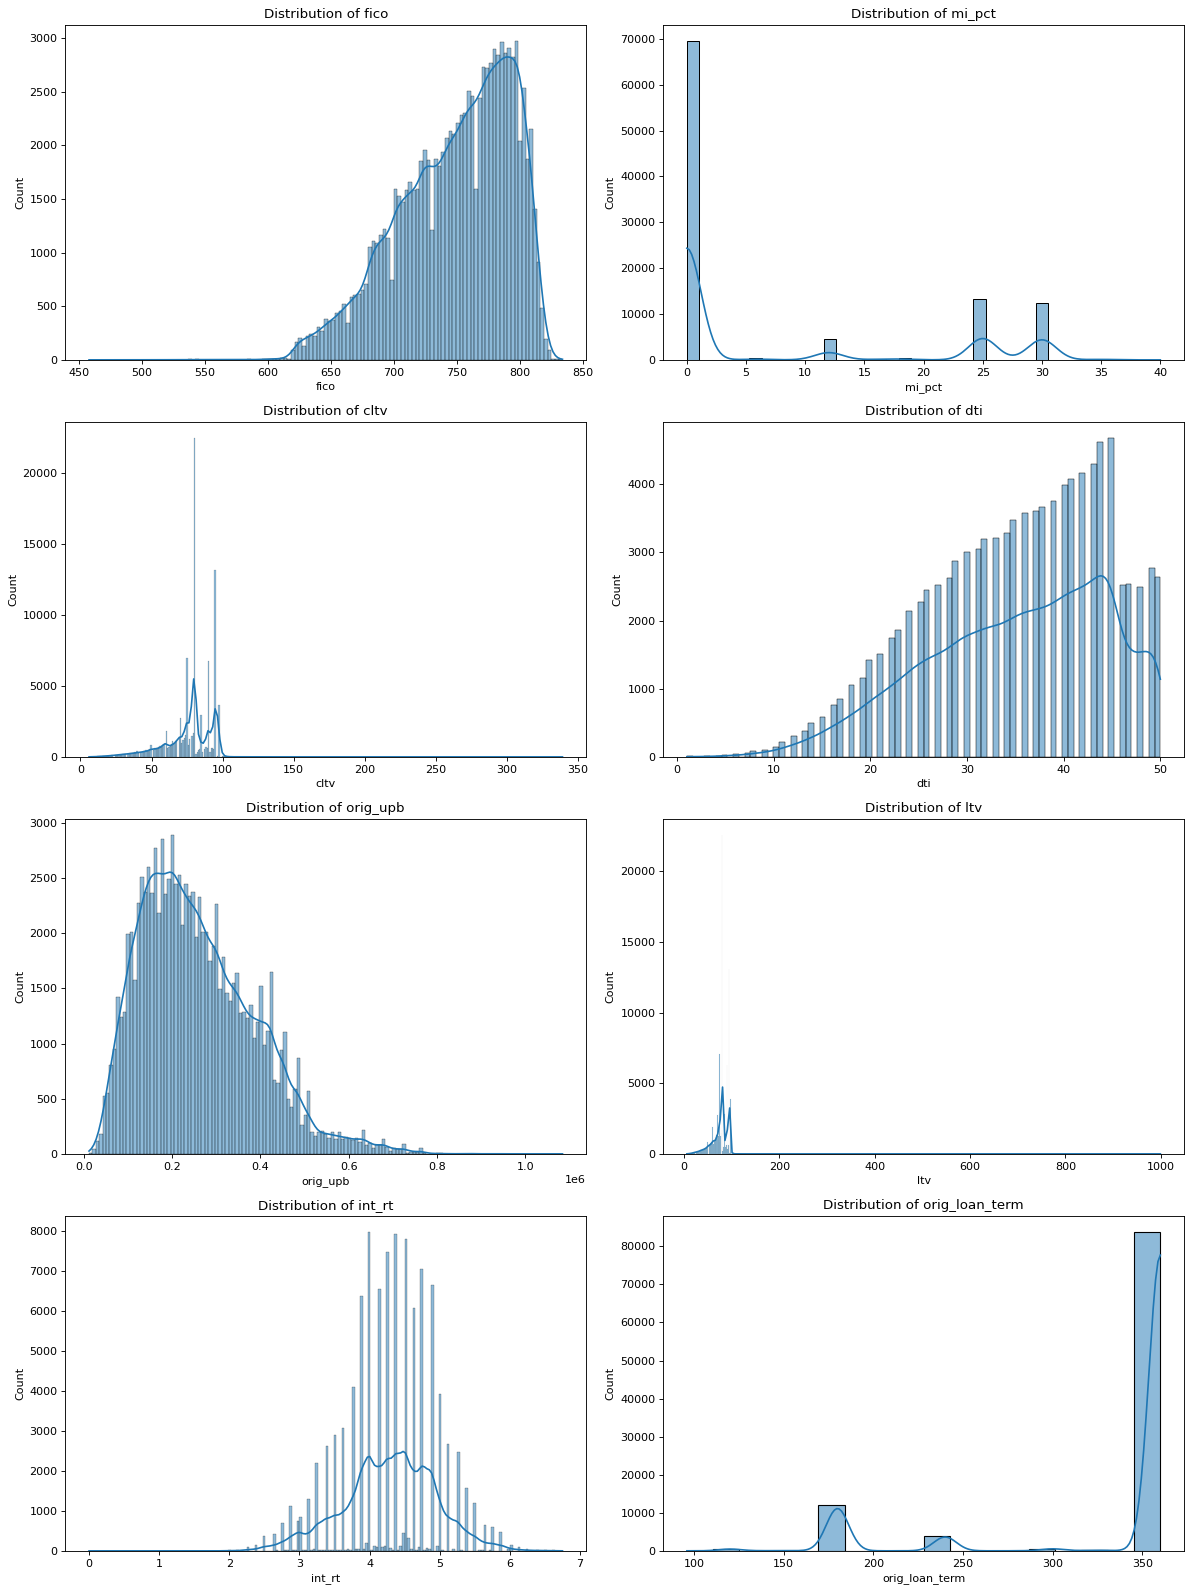

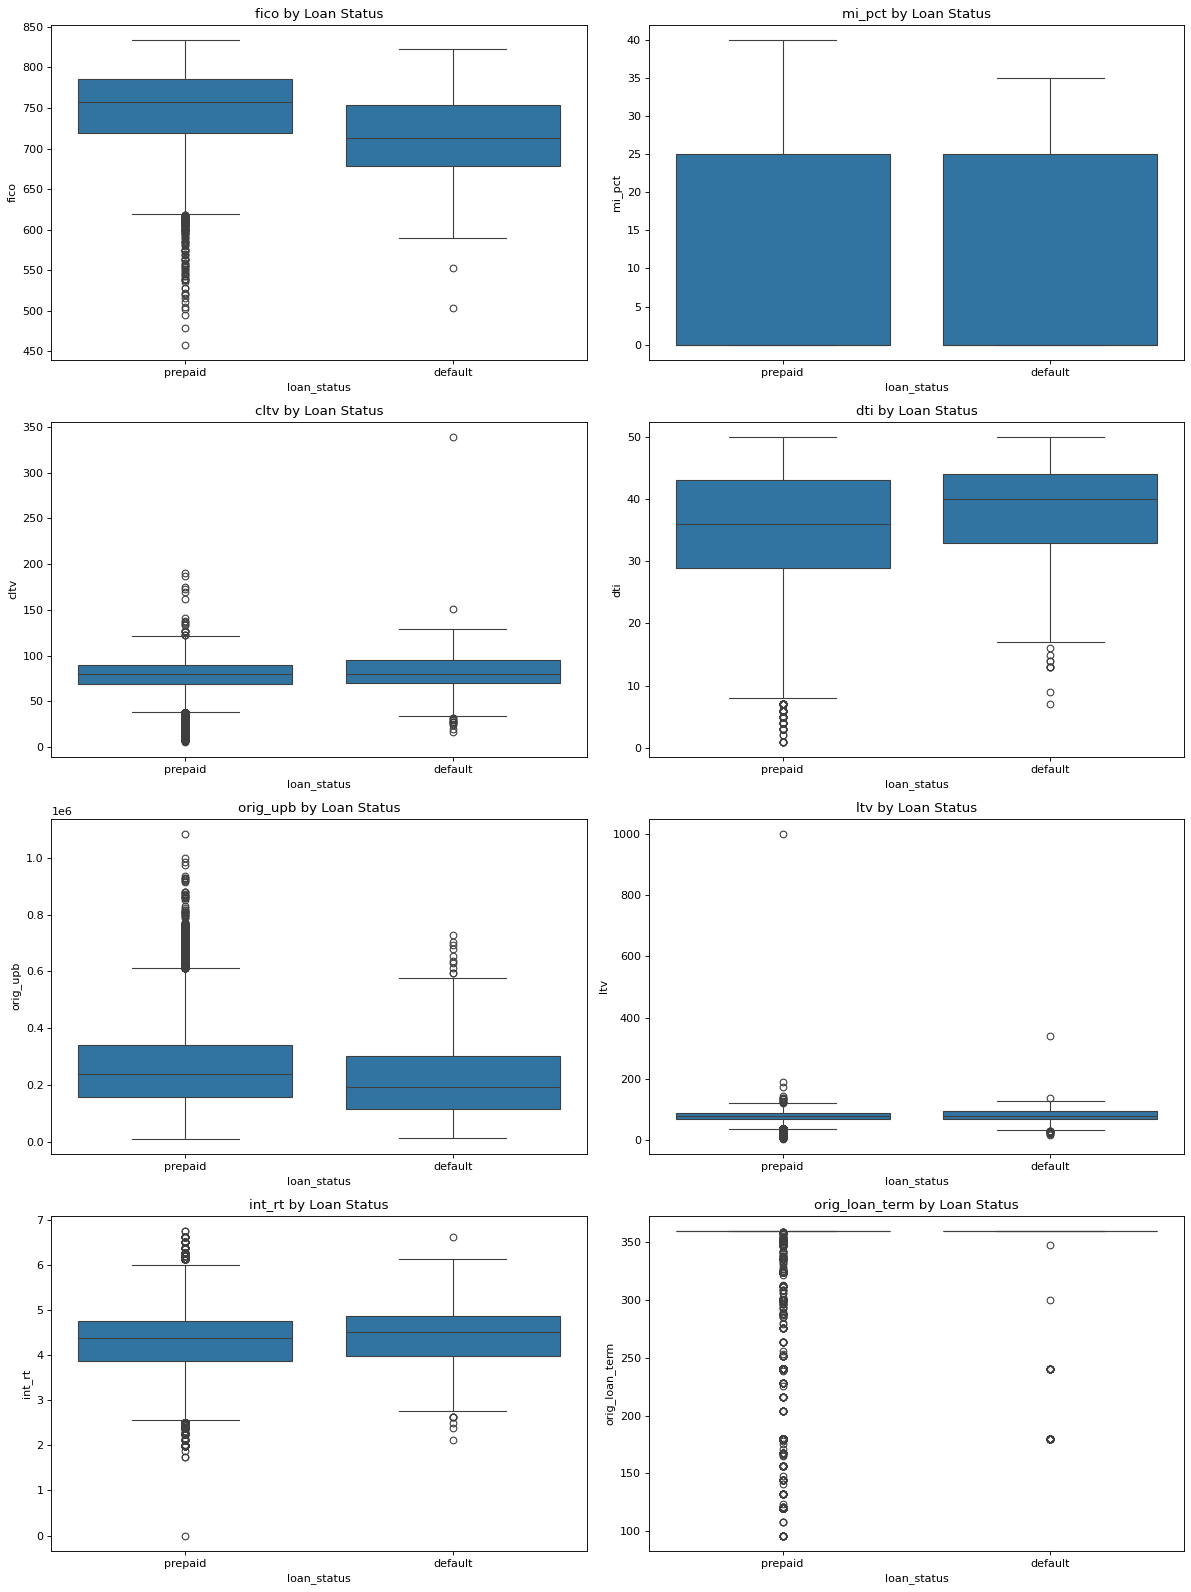

In [7]:
# ## 5. Exploratory Data Analysis

# ### 5.1 Numerical Features Analysis

# Select key numerical features
num_cols = ['fico', 'mi_pct', 'cltv', 'dti', 'orig_upb', 'ltv', 'int_rt', 'orig_loan_term']
train_num = train_df[num_cols]

# Summary statistics
print("Numerical Features Summary:")
print(train_num.describe())

# Plot distributions
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(data=train_num, x=col, ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Boxplots vs. target
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(data=train_df, x='loan_status', y=col, ax=axes[i], 
                order=['prepaid', 'default'])
    axes[i].set_title(f'{col} by Loan Status')
plt.tight_layout()
plt.show()

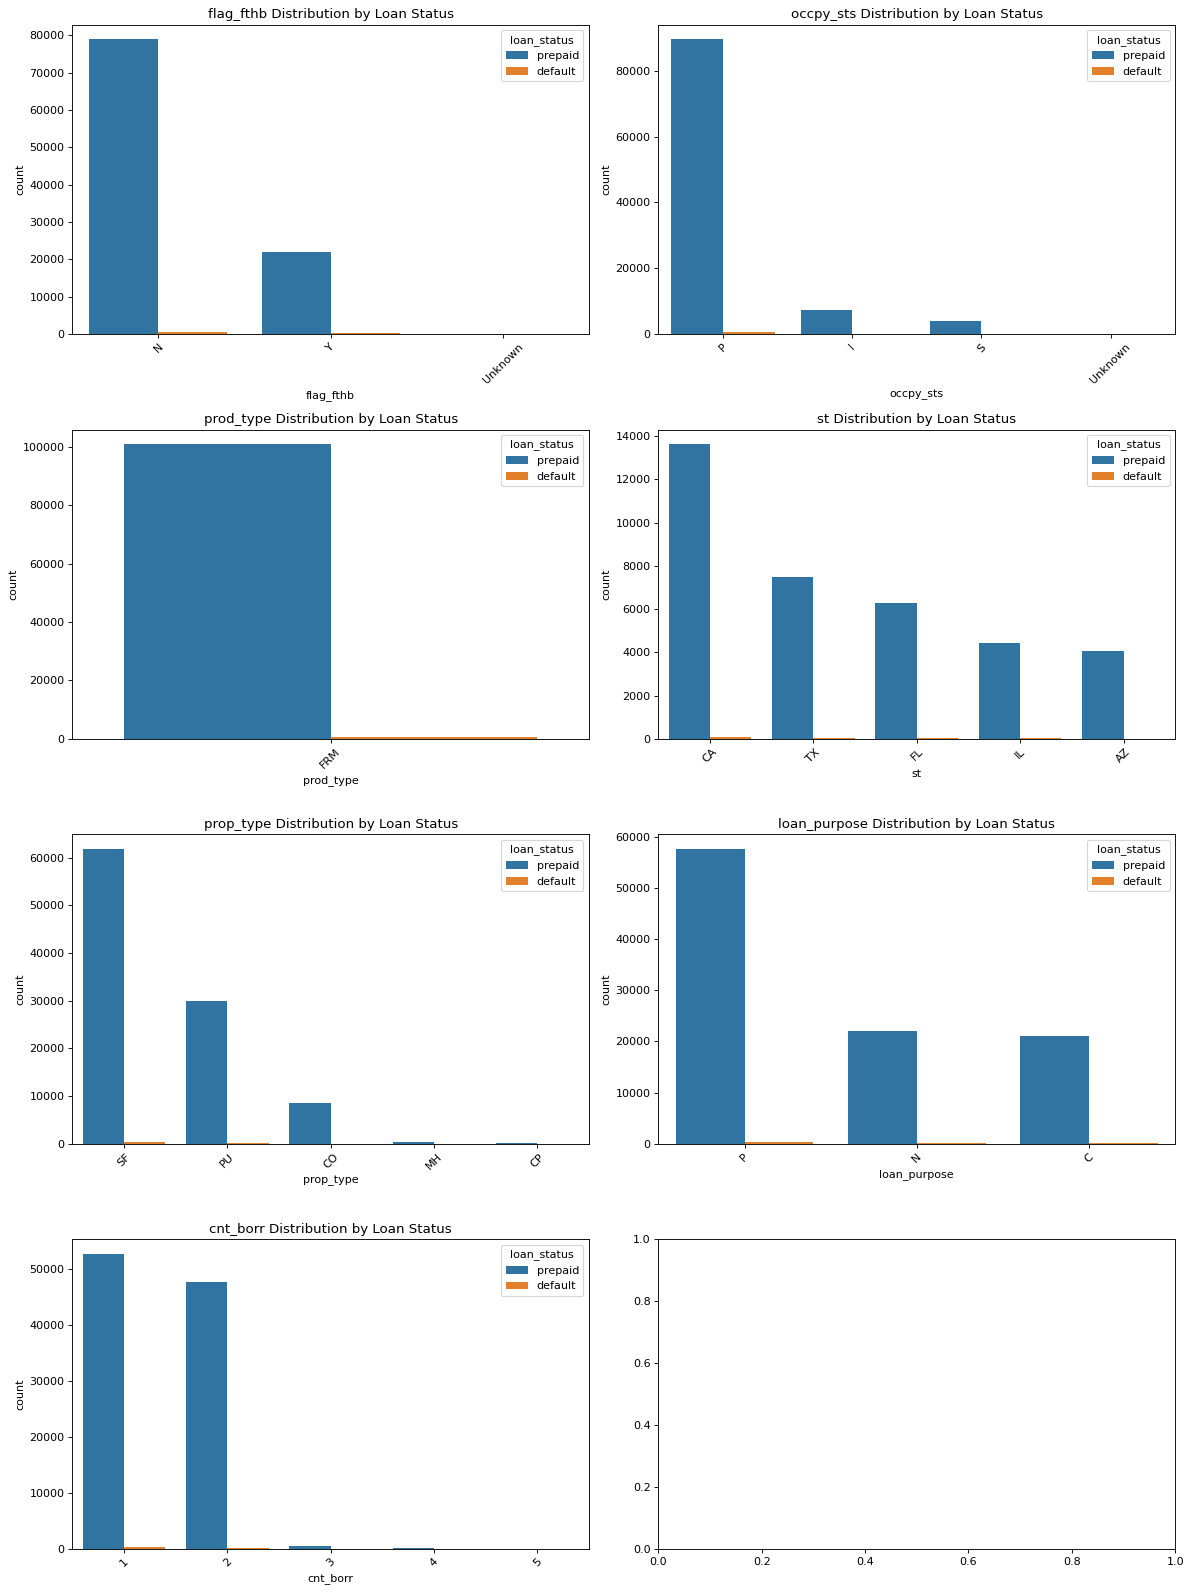

In [8]:
# ### 5.2 Categorical Features Analysis

# Select key categorical features
cat_cols = ['flag_fthb', 'occpy_sts', 'prod_type', 'st', 'prop_type', 'loan_purpose', 'cnt_borr']

# Plot distributions
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    if i >= len(axes): break
    sns.countplot(data=train_df, x=col, hue='loan_status', ax=axes[i],
                  order=train_df[col].value_counts().index[:5])  # Top 5 categories
    axes[i].set_title(f'{col} Distribution by Loan Status')
    axes[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

Correlation with Default Status:
          Feature  Correlation
6          int_rt     0.018425
5             ltv     0.012435
7  orig_loan_term     0.004832
4        orig_upb    -0.020424
0            fico          NaN
1          mi_pct          NaN
2            cltv          NaN
3             dti          NaN


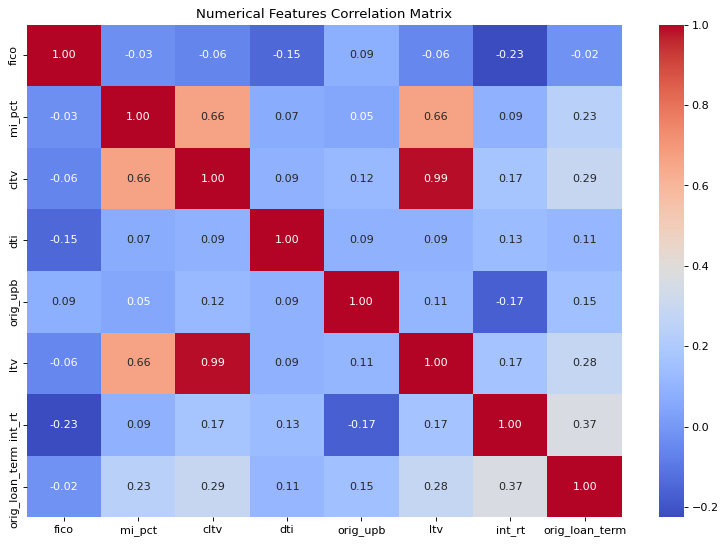

In [9]:
# ### 5.3 Correlation Analysis

# Calculate correlations with target (point-biserial)
correlations = []
for col in num_cols:
    corr = np.corrcoef(train_df[col], (train_df['loan_status'] == 'default').astype(int))[0,1]
    correlations.append(corr)

corr_df = pd.DataFrame({'Feature': num_cols, 'Correlation': correlations})
corr_df = corr_df.sort_values('Correlation', ascending=False)
print("Correlation with Default Status:")
print(corr_df)

# Plot correlation heatmap for numerical features
plt.figure(figsize=(12,8))
sns.heatmap(train_num.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Numerical Features Correlation Matrix")
plt.show()

In [10]:
# ## 6. Feature Engineering

# ### 6.1 Create New Features

# Loan term from dates (maturity date - first payment date)
train_df['dt_first_pi'] = pd.to_datetime(train_df['dt_first_pi'], format='%Y%m')
train_df['dt_matr'] = pd.to_datetime(train_df['dt_matr'], format='%Y%m')
train_df['loan_term_months'] = (
    (train_df['dt_matr'].dt.year - train_df['dt_first_pi'].dt.year) * 12 +
    (train_df['dt_matr'].dt.month - train_df['dt_first_pi'].dt.month)
)

# Drop original date columns
train_df.drop(['dt_first_pi', 'dt_matr'], axis=1, inplace=True)

# ### 6.2 Handle Class Imbalance (SMOTE will be applied during modeling)
# Note: Class imbalance handling will be done in the modeling phase using SMOTE

# ### 6.3 Prepare Final Feature Set
# Identify final features for modeling
final_features = num_cols + cat_cols + ['loan_term_months']

# Drop irrelevant columns (ID columns, high-cardinality features)
cols_to_drop = ['id_loan', 'seller_name', 'servicer_name', 'zipcode', 'id_loan_rr']
train_df = train_df.drop(columns=cols_to_drop)

# Model Fitting and Tuning

*In this section you should detail and motivate your choice of model and describe the process used to refine, tune, and fit that model. You are encouraged to explore different models but you should NOT include a detailed narrative or code of all of these attempts. At most this section should briefly mention the methods explored and why they were rejected - most of your effort should go into describing the final model you are using and your process for tuning and validating it.*

*This section should include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.*

*Finally, you should also provide a comparison of your model with a baseline model of your choice on the test data but only briefly describe the baseline model considered.*

# Discussion & Conclusions

*In this section you should provide a general overview of your final model, its performance, and reliability. You should discuss what the implications of your model are in terms of the included features, estimated parameters and relationships, predictive performance, and anything else you think is relevant.*

*This should be written with a target audience of a banking official, who is understands the issues associated with mortgage defaults but may only have university level mathematics (not necessarily postgraduate statistics or machine learning). Your goal should be to highlight to this audience how your model can useful. You should also discuss potential limitations or directions of future improvement of your model.*

*Finally, you should include recommendations on factors that may increase the risk of default, which may be useful for the companies to improve their understanding of
mortgage defaults, and also to explain their decisions to clients and regulatory bodies. You should also use your model to inform the company of any active loans that are at risk of default.*

*Keep in mind that a negative result, i.e. a model that does not work well predictively, that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explinations / justifications.*

# Generative AI statement

*Include a statement on how generative AI was used in the project and report.*

# References

*Include references if any*

In [ ]:
# Run the following to render to PDF
!jupyter nbconvert --to pdf project2.ipynb